# Reading the data

In [118]:
# basic imports
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

dataPath = "../data/"

In [ ]:
# reading CSV file
reader = csv.reader(open(dataPath + 'features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open(dataPath + 'all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))

In [ ]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

In [ ]:
print receptor_names

# Training classifiers and printing results

In [53]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold as SKF
import sklearn
from scipy.special import expit

In [54]:
import PCC
import MLCCommon
reload(MLCCommon)

<module 'MLCCommon' from 'MLCCommon.py'>

In [55]:
#Sigma(0)
print MLCCommon.Sigma(np.array([1,2,3]))


print expit(np.array([1,2,3]))

[ 0.73105858  0.88079708  0.95257413]
[ 0.73105858  0.88079708  0.95257413]


# Model data

In [116]:
randomState = 1234
    
def BRShow(X, Y, folds):
    IFolds = sklearn.cross_validation.KFold(n = X.shape[0], n_folds=folds, shuffle=True,
                                   random_state=randomState)
    #IFolds = SKF(Y, folds)
    maxC = 3

    roc_auc = np.zeros((folds, maxC))
    subsetLossArr = np.zeros(folds)
    fold = 0
    for ITrain, ITest in IFolds:
        # get train & test data
        XTrain, YTrain = X[ITrain], Y[ITrain]
        XTest,  YTest  = X[ITest],  Y[ITest]

        subsetLossTemp = np.zeros(YTest.shape)
        
        for i in range(maxC):
            classifier = LR(class_weight = 'balanced')
            classifier.fit(XTrain, YTrain[:,i])

            # get predicted probabilities for class
            YScore = classifier.predict_proba(XTest)[:, 1]
            
            subsetLossTemp[:, i] = (classifier.predict(XTest) == YTest[:, i])

            # calculate fpr and tpr
            fpr, tpr, _ = roc_curve(YTest[:,i], YScore)
            
            plotROCCurve(fpr, tpr, "Fold %d Class %d ROC" % (fold + 1, i + 1), None)
            roc_auc[fold][i] = auc(fpr, tpr)
        subsetLossArr[fold] = 1. * len(np.where(np.all(subsetLossTemp, axis = 1)==0)[0]) / XTest.shape[0]
        fold += 1

    for i in range(maxC):
        auc_mean = np.mean(roc_auc[:, i])
        auc_std = np.std(roc_auc[:, i])
        print("Class %d AUC %.2g +- %.1g" % (i + 1, auc_mean, auc_std))
    subset_mean = np.mean(subsetLossArr)
    subset_std = np.std(subsetLossArr)
    print("SUBSET %.5f %.1f" % (subset_mean, subset_std))
def PCCShow(X, Y, folds, thr = 0.2, do_new = False):
    IFolds = sklearn.cross_validation.KFold(n = X.shape[0], n_folds=folds, shuffle=True,
                                   random_state=randomState)
    #IFolds = SKF(Y, folds)
    maxC = 3

    roc_auc = np.zeros((folds, maxC))
    fold = 0
    subsetLossArr = np.zeros(folds)
    for ITrain, ITest in IFolds:
        # get train & test data
        XTrain, YTrain = X[ITrain], Y[ITrain]
        XTest,  YTest  = X[ITest],  Y[ITest]

        Ys = np.zeros(YTest.shape)

        algo = PCC()
        algo.initialize(YTrain.shape[1], XTrain, YTrain, 999)
        for i in range(maxC):
           # print("fit %d" % i)
            algo.fitOne(i)
          #  print("adjust %d" % i)
           # algo.adjustOne(i, thr)

    #    print("calculating ROC...")

        subsetLoss = 0
        P = np.zeros(YTest.shape[1])
        N = np.zeros(YTest.shape[1])
        FP = np.zeros(YTest.shape[1])
        TP = np.zeros(YTest.shape[1])
        
        for j in range(XTest.shape[0]):
            if do_new:
                Ys[j] = algo.probabilityClassesNew(XTest[j])
            else:
                Ys[j] = algo.probabilityClasses(XTest[j])
            #ans1 = algo.probabilityClassesSubset(XTest[j])
            ans1 = algo.predictMinimizeLoss(XTest[j])
            ans2 = YTest[j]
            if np.any(ans1 != ans2):
                subsetLoss += 1
               # print("Got error j=%d ans1 = %s ans2 = %s" % (j, str(ans1), str(ans2)))
            for i in range(YTest.shape[1]):
                if ans2[i] == 1:
                    P[i] += 1
                else:
                    N[i] += 1
                if ans1[i] == 1 and ans2[i] == 1:
                    TP[i] += 1
                if ans1[i] == 1 and ans2[i] == 0:
                    FP[i] += 1
        for i in range(YTest.shape[1]):
            print("FOLD %d CLASS %d P=%d N=%d FPR=%lf TPR=%lf" % (fold, i, P[i], N[i], 1. * FP[i] / N[i], 1. * TP[i] / P[i]))
                    
        subsetLossArr[fold] = 1. * subsetLoss / XTest.shape[0]
            

        for i in range(maxC):
            ind = np.where(YTest[:, i] != 999)
            X1 = XTest[ind]
            Y1 = YTest[ind, i][0]
            Ys0 = Ys[ind, i][0]

            fpr, tpr, _ = roc_curve(Y1, Ys0)
            #plotROCCurve(fpr, tpr, "Fold %d Class %d ROC" % (fold + 1, i + 1), None)
            roc_auc[fold][i] = auc(fpr, tpr)
            
        Xshow = np.arange(-0.6, 0.6, 0.01)
        plt.figure(figsize=(10, 10))
        plt.xlim([-1, 1])
        plt.ylim([-0.1, 1.05])
        for v in getB(l):
            c = v
            if c == [1, 1, 1]:
                c = [0.5, 0.5, 0.5]
            YShow = np.zeros(Xshow.shape[0])
            for i in range(Xshow.shape[0]):
                item = Xshow[i]
                item = [item]
                YShow[i] = algo.probabilityItem(item, v)
            plt.plot(Xshow, YShow, color=c, label=str(v))
        plt.legend(loc=2,prop={'size':8})
        plt.show()

        Xmr=np.array([Xm]).T
            
        fold += 1

    for i in range(maxC):
        auc_mean = np.mean(roc_auc[:, i])
        auc_std = np.std(roc_auc[:, i])
        print("Class %d AUC %.2g +- %.1g" % (i + 1, auc_mean, auc_std))
    subset_mean = np.mean(subsetLossArr)
    subset_std = np.std(subsetLossArr)
    print("SUBSET %.5f %.1f" % (subset_mean, subset_std))

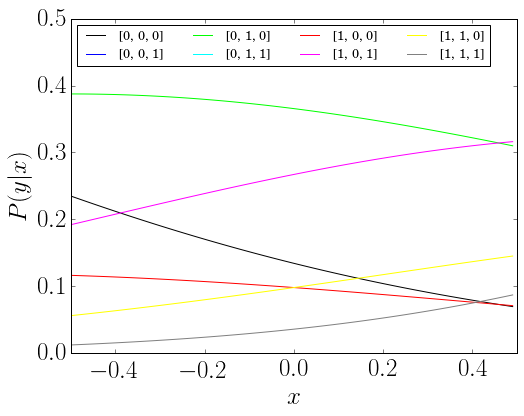

In [114]:
import ModelData
reload(ModelData)            

ModelData.plotDistribution()

Xm, Ym = ModelData.get()
Xm=np.array([Xm]).T

In [119]:
BRShow(Xm, Ym, 2)
print("==")
PCCShow(Xm, Ym, 2, thr = 0.3)
#print("==")
#PCCShow(Xmr, Ym, 2, do_new = True, thr = 0.7)

NameError: global name 'plt' is not defined